In [50]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits as mplot3d
import seaborn as sns
from copy import deepcopy
from scipy import stats
from matplotlib.colors import Normalize
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Prep data

### Instructions
To run this notebook, you will have to download the "Adult human, chimpanzee, macaque data" from http://evolution.psychencode.org/#

Keep track of where you save the data to. Might be simples to save it into the data/ directory of this repo

In [2]:
# change this to the location of the saved data
df = pandas.read_csv('./data/PEC_nhp_melt.csv')

In [56]:
figdir = './figures/'

#### Harmonize data
First we want to harmonize the dataset with Allen and pull out the PLS Components for each of the samples here

In [3]:
df.loc[:,'gene_symbol'] = [x.split('|')[-1] for x in df.ProbeID.values]

In [4]:
# This dataframe was created in the N3_PLS_ModelExploration notebook
allcomps = pandas.read_csv('./data/all_comps.csv',index_col=0)
allcomps.index = allcomps.gene_symbol.values
allcomps.head()

,C1,gene_symbol,gene_name,C2,C3,C1_genelist,C2_genelist,C3_genelist
A1BG,0.001956,A1BG,alpha-1-B glycoprotein,0.003711,-0.021865,0.0,0.0,1.0
A1BG-AS1,-0.007211,A1BG-AS1,NaN,-0.007837,-0.003920,0.0,0.0,0.0
A2M,0.005342,A2M,alpha-2-macroglobulin,0.008298,0.001742,0.0,0.0,0.0
A2ML1,-0.007153,A2ML1,alpha-2-macroglobulin-like 1,-0.004419,-0.006947,0.0,0.0,0.0
A3GALT2,-0.002024,A3GALT2,NaN,0.001295,0.002109,0.0,0.0,0.0


In [5]:
# find common genes across datasets
shared = set(df.gene_symbol.values) & set(allcomps.index)

In [6]:
# crop to shared genes
df = df[df.gene_symbol.isin(shared)]

Here, we're calculating the PLS Component expression for each component for each human and primate tissue sample available.

In [56]:
# There is surely a faster way of doing this but I was lazy.
# Took awhile to run on my computer

gdf = pandas.DataFrame()
count = 0
# for each subject
for i,ID in enumerate(df.ID.unique()):
    print('working on %s of 16'%(i+1))
    # for each region
    for region in df.ROI.unique():
        # pull out relevant data
        jnk = pandas.DataFrame(df[(df.ROI==region) & (df.ID==ID)],copy=True)
        if jnk.shape[0] == 0: continue # skip if region missing
        # add info to new spreadsheet
        gdf.loc[count,'ID'] = jnk.iloc[0]['ID']
        gdf.loc[count,'ROI'] = jnk.iloc[0]['ROI']
        gdf.loc[count,'Species'] = jnk.iloc[0]['Species']
        # prep for dot product (aka the "prediction")
        jnk.index = jnk.gene_symbol.values
        jnk = jnk.loc[shared]
        # find PLS expression for each component
        for c in range(1,4):
            gdf.loc[count,'C%s_exp'%c] = np.dot(jnk['value'].values,
                                             allcomps.loc[jnk.index,'C%s'%c].values)
        count+=1

working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16


In [58]:
# Might want to save that so you don't have to do it again

#gdf.to_csv('./data/PEC_nhp_indiv_withCs.csv')

In [7]:
# And load it to start from here
# gdf = pandas.read_csv('./data/PEC_nhp_indiv_withCs.csv',
#                      index_col=0)

In [8]:
# list the regions in the dataset
gdf.ROI.value_counts()

OFC    16
VFC    16
HIP    16
ITC    16
STC    16
AMY    16
S1C    16
IPC    16
STR    15
M1C    15
V1C    15
MD     15
DFC    15
A1C    15
CBC    15
MFC    14
Name: ROI, dtype: int64

In [9]:
# map each region to one of the AHBA regions
mapper = {'Sensorimotor': ['S1C','M1C'],
          'Limbic': ['HIP','AMY'],
          'Cerebellum': ['CBC'],
          'Forebrain': ['NAC'],
          'Striatum': ['STR'],
          'Frontal': ['OFC','VFC','DFC','MFC'],
          'Temporal': ['STC','A1C'],
          'Parietal': ['IPC','ITC'],
          'Occipital': ['V1C'],
          'Thalamus': ['MD']
         }
for name, div in mapper.items():
    gdf.loc[gdf[gdf.ROI.isin(div)].index,'MacroStructure'] = name

In [11]:
# remove outliers
#gdf.drop([1099,777],inplace=True)

# Visualization (for fun)
For fun, we can visualize the dispersion of smaples across components


Human


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


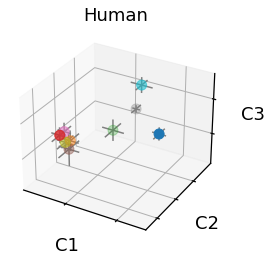

Chimpanzee


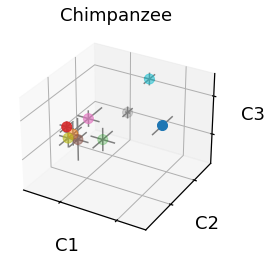

Macaque


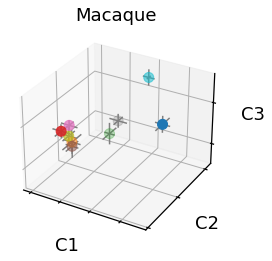

In [26]:
sns.set_context('notebook',font_scale=1.5)

# for each species separately
for species in gdf.Species.unique():
    if not pandas.notnull(species): continue
    print(species)
    adf = gdf[gdf.Species==species]
    # get means and sds across donors
    means = adf.groupby('MacroStructure')[['C1_exp','C2_exp','C3_exp']].mean()
    stds = adf.groupby('MacroStructure')[['C1_exp','C2_exp','C3_exp']].std()
    stds.columns = ['C1_sd','C2_sd','C3_sd']
    # set up plotting dataframe for easy reference
    plotr = pandas.concat([means,stds],axis=1)
    plotr.loc[:,'region'] = plotr.index
    # start building plot
    ax = plt.axes(projection='3d')
    # plot confidence intervals across all three dimensions
    for i,row in plotr.iterrows():
        c1_mn = row['C1_exp']
        c2_mn = row['C2_exp']
        c3_mn = row['C3_exp']
        c1_sd = row['C1_sd']
        c2_sd = row['C2_sd']
        c3_sd = row['C3_sd']
        ax.plot3D([c1_mn-c1_sd,c1_mn+c1_sd], [c2_mn,c2_mn], [c3_mn,c3_mn], 'gray')
        ax.plot3D([c1_mn,c1_mn], [c2_mn-c2_sd,c2_mn+c2_sd], [c3_mn,c3_mn], 'gray')
        ax.plot3D([c1_mn,c1_mn], [c2_mn,c2_mn], [c3_mn-c3_sd,c3_mn+c3_sd], 'gray')
    # plot markers
    ax.scatter3D(plotr.C1_exp, plotr.C2_exp, plotr.C3_exp, c=range(len(plotr)),cmap='tab10',
                s=100)
    # decorate
    plt.xlabel('C1')
    plt.ylabel('C2')
    ax.set_zlabel('C3')
    ax.set_xticklabels(['' for x in ax.get_xticklabels()])
    ax.set_yticklabels(['' for x in ax.get_yticklabels()])
    ax.set_zticklabels(['' for x in ax.get_zticklabels()])
    ax.set_title(species)
    plt.show()

# Calculate reproduction of PLS Components
Here we are using the same logic we did in the `GTExWorkup.ipynb` and `BrainSpanValidation.ipynb` notebooks. We are seeing how well the PLS Components trained in AHBA replicate in *individuals* across these three datasets. Importantly, two of the datasets are non-human primates, which include data from macaques and chimps, respectively

The code below is copied (and adapted) from code used in `GTExWorkup.ipynb` and `BrainSpanValidation.ipynb`, so see these notebooks for more thorough documentation

#### First across entire human dataset (to compare to other replications)

In [46]:
abac2 = pandas.read_csv('data/GCorr_BSComp_ABA_C2_data.csv',
                       index_col=0)
abac2.columns = ['ABA_mean','ABA_sem']
print('shared:',set(abac2.index) & set(gdf.MacroStructure.unique()))
print('missing:',set(gdf.MacroStructure.unique()) - set(abac2.index))

bsc2 = pandas.pivot_table(gdf,
                            #gdf[gdf.Age_Stage=='adult'],
                          values='C2_exp',
                             index='MacroStructure',aggfunc=np.mean
                            )
for div in bsc2.index:
    sem = gdf[gdf.MacroStructure==div]['C2_exp'].sem()
    bsc2.loc[div,'sem'] = sem
bsc2.columns = ['BS_mean','BS_sem']

c2_comp = pandas.concat([bsc2,abac2],axis=1,sort='True').dropna()
c2_comp.loc[:,'region'] = c2_comp.index
c2_comp.head()

shared: {'Striatum', 'Cerebellum', 'Thalamus', 'Limbic', 'Occipital', 'Temporal', 'Sensorimotor', 'Parietal', 'Frontal'}
missing: set()


,BS_mean,BS_sem,ABA_mean,ABA_sem,region
Cerebellum,-0.695666,0.812460,-0.245697,0.002831,Cerebellum
Frontal,0.472537,0.467050,-0.139174,0.004629,Frontal
Limbic,9.122409,0.627319,0.091255,0.008090,Limbic
Occipital,-7.861974,0.771122,-0.399042,0.006815,Occipital
Parietal,-0.771218,0.666824,-0.307387,0.005913,Parietal


In [51]:
# z-score data to account for standardized vs. non-standardize nature of the two datasets
n_comps = 3
for i in range(1,(n_comps+1)):
    vals = StandardScaler().fit_transform(gdf.loc[:,'C%s_exp'%i
                                                 ].values.reshape(-1,1)
                                         )[:,0]
    gdf.loc[:,'zC%s_exp'%i,] = vals

r = 0.95, p = 0.0


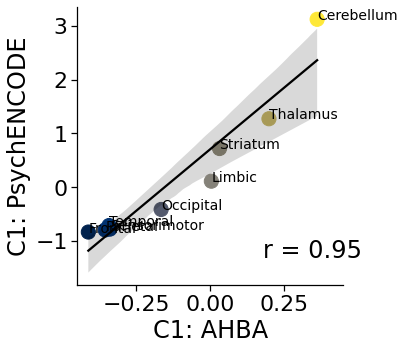

r = 0.962, p = 0.0


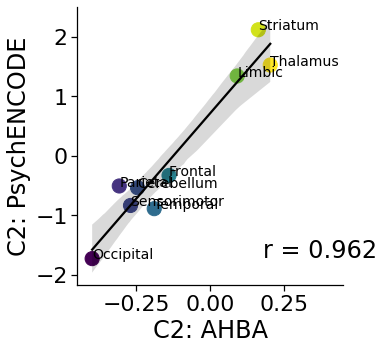

r = 0.787, p = 0.012


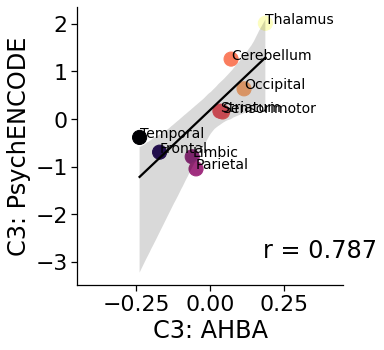

In [60]:
# note this analysis is only performed on the adult brainspan samples
sns.set_context('notebook',font_scale=2)
pals = ['cividis','viridis','magma']
for i in range(1,(n_comps+1)):
    # read allen data
    aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data.csv'%i,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    # prep brainspan data
    bs = pandas.pivot_table(#gdf,
                            gdf[gdf.Species=='Human'],# just the humans!
                          values='zC%s_exp'%i,
                             index='MacroStructure',aggfunc=np.mean
                            )
    # calculate SEM (I don't think i actually use this)
    for div in bs.index:
        sem = gdf[gdf.MacroStructure==div]['zC%s_exp'%i].sem()
        bs.loc[div,'sem'] = sem
    bs.columns = ['PEC_mean','PEC_sem']
    # build comparison dataframe
    comp = pandas.concat([bs,aba],axis=1,sort='True').dropna()
    comp.loc[:,'region'] = c2_comp.index
    
    # colors
    cmap = sns.color_palette(pals[i-1],as_cmap=True)
    sg = comp.ABA_mean.values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))
    
    # plot
    g=sns.lmplot(x='ABA_mean',y='PEC_mean',data=comp,
           scatter_kws={'marker':'o','s':200,'color':cscale},
               line_kws={'color':'k'}
          )
    # stats
    r,p = stats.pearsonr(comp.ABA_mean.values,comp.PEC_mean.values)
    print('r = %s, p = %s'%(round(r,3),round(p,3)))
    # decorate
    for it,div in enumerate(comp.sort_values('ABA_mean').index):
        x = comp.loc[div,'ABA_mean']
        y = comp.loc[div,'PEC_mean']
        dist = len(div)*.02
        if it%2==0:
            plt.text(x, y,div,{'size':14})
        else:
            plt.text(x, y,div,{'size':14},
                     )
    plt.xlabel('C%s: AHBA'%i)
    plt.ylabel('C%s: PsychENCODE'%i)
    plt.text(0.7,0.1,'r = %s'%round(r,3),transform=g.ax.transAxes)
    plt.xlim(-.45,.45)
    plt.savefig(os.path.join(figdir,'PsyENC_Repl_C%s.pdf'%i), bbox_inches='tight')
    plt.show()

#### Now across individual species

In [12]:
gpdfs = {}
for i in range(1,4):
    gpdf = gdf[['ID','C%s_exp'%i,'MacroStructure']
                  ].set_index(['ID'],append=True
                             ).pivot_table(index='ID',
                                           columns='MacroStructure',
                                           values='C%s_exp'%i)
    #gpdf.drop('GangEm',axis=1,inplace=True)
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    gpdfs.update({i: gpdf})
    

In [13]:
for c in range(1,4):
    cdf = gpdfs[c]
    aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data.csv'%c,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    aba = aba.loc[cdf.columns[:-1]]
    for i,row in cdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        if row['n_valid'] > 4:
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            cdf.loc[i,'C%s_r'%c] = r
            cdf.loc[i,'C%s_rho'%c] = rho

In [14]:
cols = ['ID', 'Species',]
subsum = pandas.DataFrame(gpdfs[1].index)
for col in cols:
    subsum.loc[:,col] = gdf.groupby('ID')[col].first().values
for c in range(1,4):
    subsum.loc[:,'C%s_r'%c] = gpdfs[c].loc[:,'C%s_r'%c].values
    subsum.loc[:,'C%s_rho'%c] = gpdfs[c].loc[:,'C%s_rho'%c].values
    subsum.loc[:,'n_valid'] = gpdfs[c].loc[:,'n_valid'].values

Now that we have the individual level correlations to AHBA components across all individuals and species, let's plot them!

In [15]:
# Melt the dataset for easier plotting
subsum.loc[:,'ind'] = range(len(subsum))
tall = subsum.melt('ind',['C1_r','C2_r','C3_r'],'component','expr')
tall.loc[:,'Species'] = subsum.Species.tolist() * 3

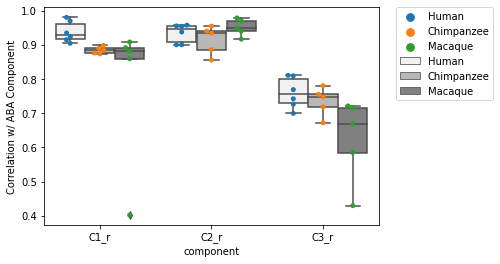

In [16]:
# Plot
sns.swarmplot(x='component',y='expr',hue='Species',data=tall,dodge=True)
sns.boxplot(x='component',y='expr',hue='Species',data=tall,color='gray')
plt.ylabel('Correlation w/ ABA Component')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

What's up with that one outlier macaque?

In [32]:
tall[tall.expr<0.5]

,ind,component,expr,Species
15,15,C1_r,0.402082,Macaque
47,15,C3_r,0.429572,Macaque


In [33]:
gdf[gdf.ID=='RMB219L'].MacroStructure.value_counts()

Frontal         4
Parietal        2
Sensorimotor    2
Limbic          2
Occipital       1
Temporal        1
Striatum        1
Name: MacroStructure, dtype: int64

So this subject's correlation is worse because no subcortical or cerebellar data. Very interesting. Also interesting this didn't seem to affect the data for C2

In [29]:
#tall[tall.component=='C3_r']

Let's do a quick two-way ANOVA to test if there are significant differences in similarity to the discovery dataset by species, by component, or an interaction

In [32]:
mod = smf.ols('expr ~ C(Species) + C(component) + C(Species):C(component)', data=tall).fit()
table = sm.stats.anova_lm(mod, typ=2)

In [61]:
table

,sum_sq,df,F,PR(>F)
C(Species),0.065990,2.0,4.543859,1.683036e-02
C(component),0.431285,2.0,29.697092,1.454976e-08
C(Species):C(component),0.053836,4.0,1.853506,1.381833e-01
Residual,0.283195,39.0,NaN,NaN


In [63]:
print(pairwise_tukeyhsd(tall.expr, groups=tall['Species']))

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2 meandiff p-adj   lower  upper  reject
--------------------------------------------------------
Chimpanzee   Human   0.0329 0.7349 -0.0778 0.1436  False
Chimpanzee Macaque  -0.0565  0.471 -0.1721 0.0592  False
     Human Macaque  -0.0894 0.1348 -0.2001 0.0213  False
--------------------------------------------------------


In [44]:
print(pairwise_tukeyhsd(tall.expr, groups=tall['component']))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  C1_r   C2_r   0.0586 0.1979 -0.0225  0.1397  False
  C1_r   C3_r  -0.1653  0.001 -0.2464 -0.0842   True
  C2_r   C3_r  -0.2239  0.001  -0.305 -0.1428   True
----------------------------------------------------


# Null model

These correlations are all really high, and I think it's natural to wonder if the data guarantees a high correlation. So, in order to test if the within-subject r-values are greater than chance given the data, and to extract exact p-values, we'll do a bit of null modeling.

In [282]:
n_iter = 100 # number of iterations, 100 should be fine for now
results = []

# for each iteration
for it in range(n_iter):
    # do shuffle
    print('working on iteration',(it+1),'of',n_iter)
    print('calculating random expression')
    randies = {}
    # for each component
    for c in range(1,4):
        # set the random state
        prng = np.random.RandomState(123+it)
        # shuffle the gene expression data
        arr = allcomps.loc[shared,'C%s'%c]
        rarr = prng.choice(arr.values,len(arr),replace=False)
        rarr = pandas.Series(rarr,index=arr.index)
        randies.update({c:rarr})
    # prep a null results data frame
    jdf = pandas.DataFrame()
    catch = []
    count = 0
    # run same code as above to go through each subject and region
    for i,ID in enumerate(df.ID.unique()):
        print('working on %s of 16'%(i+1))
        for region in df.ROI.unique():
            jnk = pandas.DataFrame(df[(df.ROI==region) & (df.ID==ID)],copy=True)
            if jnk.shape[0] == 0: continue
            jdf.loc[count,'ID'] = jnk.iloc[0]['ID']
            jdf.loc[count,'ROI'] = jnk.iloc[0]['ROI']
            jdf.loc[count,'Species'] = jnk.iloc[0]['Species']
            jnk.index = jnk.gene_symbol.values
            jnk = jnk.loc[shared]
            # apply PLS weights to randomly shuffled data
            for c in range(1,4):
                jdf.loc[count,'C%s_exp'%c] = np.dot(jnk['value'].values,
                                                 randies[c].loc[jnk.index].values)
            count+=1
            #catch.append(jnk)
    
    # calculate similarity
    # same code as above, just now embedded in the loop
    print('calculating similarity')
    
    for name, div in mapper.items():
        jdf.loc[jdf[jdf.ROI.isin(div)].index,'MacroStructure'] = name
        
    jpdfs = {}
    for i in range(1,4):
        jpdf = jdf[['ID','C%s_exp'%i,'MacroStructure']
                      ].set_index(['ID'],append=True
                                 ).pivot_table(index='ID',
                                               columns='MacroStructure',
                                               values='C%s_exp'%i)
        for ind,row in jpdf.iterrows():
            n_valid = len([x for x in row.values if pandas.notnull(x)])
            jpdf.loc[ind,'n_valid'] = n_valid
        jpdfs.update({i: jpdf})
    
    for c in range(1,4):
        cjdf = jpdfs[c]
        aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data.csv'%c,
                           index_col=0)
        aba.columns = ['ABA_mean','ABA_sem']
        aba = aba.loc[cjdf.columns[:-1]]
        for i,row in cjdf.iterrows():
            forcorr = pandas.DataFrame(aba,copy=True)
            if row['n_valid'] > 4:
                forcorr.loc[:,'gvec'] = row.values[:-1]
                forcorr.dropna(inplace=True)
                r = stats.pearsonr(forcorr['ABA_mean'].values,
                                  forcorr['gvec'].values)[0]
                rho = stats.spearmanr(forcorr['ABA_mean'].values,
                                  forcorr['gvec'].values)[0]
                cjdf.loc[i,'C%s_r'%c] = r
                cjdf.loc[i,'C%s_rho'%c] = rho
    
    cols = ['ID', 'Species',]
    jsum = pandas.DataFrame(jpdfs[1].index)
    for col in cols:
        jsum.loc[:,col] = jdf.groupby('ID')[col].first().values
    for c in range(1,4):
        jsum.loc[:,'C%s_r'%c] = jpdfs[c].loc[:,'C%s_r'%c].values
        jsum.loc[:,'C%s_rho'%c] = jpdfs[c].loc[:,'C%s_rho'%c].values
        jsum.loc[:,'n_valid'] = jpdfs[c].loc[:,'n_valid'].values
    # keep track of iteration
    jsum.loc[:,'iteration'] = it
    # print results to keep track of progress
    print('='*5,it,'results','='*5)
    print(jsum.groupby('Species')[['C1_r','C2_r','C3_r']].mean())
    print('_'*20)
    # store results
    results.append(jsum)

working on iteration 1 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 0 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee -0.109106 -0.564059  0.037033
Human      -0.049593 -0.650273 -0.044184
Macaque    -0.509291 -0.398273  0.208213
____________________
working on iteration 2 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working

working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 13 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee -0.278923 -0.208568  0.399973
Human       0.072845 -0.326078  0.305314
Macaque    -0.486085  0.200945  0.091970
____________________
working on iteration 15 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 14 results =====
                C1

working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 26 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee  0.322626 -0.297407  0.486776
Human       0.459799 -0.350466  0.298329
Macaque    -0.523440 -0.176550  0.295019
____________________
working on iteration 28 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 27 results =====
                C1

working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 39 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee  0.066518 -0.411643  0.198204
Human       0.180524 -0.372644  0.093998
Macaque    -0.220629  0.051438  0.100387
____________________
working on iteration 41 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 40 results =====
                C1

working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 52 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee -0.378511  0.373829 -0.295184
Human      -0.272396 -0.251819 -0.225613
Macaque    -0.437705  0.344850 -0.404694
____________________
working on iteration 54 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 53 results =====

working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 65 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee  0.671539  0.341436  0.352778
Human       0.632779  0.082430  0.436201
Macaque     0.288222  0.452242  0.315167
____________________
working on iteration 67 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 66 results =====
                C1

working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 78 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee -0.067548 -0.193823 -0.709577
Human       0.218893 -0.346335 -0.466781
Macaque     0.243630  0.242260 -0.196280
____________________
working on iteration 80 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 79 results =====
                C1

working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 91 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee -0.143641 -0.354351 -0.461850
Human       0.206546 -0.140959 -0.606092
Macaque    -0.585580  0.087954 -0.393049
____________________
working on iteration 93 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 92 results =====
                C1

In [283]:
# concatenate results
randos = pandas.concat(results)

In [284]:
# save it, so you don't have to run that whole thing again
#randos.to_csv('./data/random_mats.csv')

In [34]:
# load it if necessary
# randos = pandas.read_csv('./data/random_mats.csv',index_col=0)

In [35]:
# build it into a summarized dataframe
randos.loc[:,'ind'] = range(len(randos)) 
rtall = randos.melt('ind',['C1_r','C2_r','C3_r'],'component','expr')
rtall.loc[:,'Species'] = ['%s_Null'%x for x in randos.Species] * 3
rtall.loc[:,'Species2'] = [x for x in randos.Species] * 3
rtall.loc[:,'ID'] = [x for x in randos.ID] * 3

In [36]:
# concatenate it with the "true" results for comparison
vtall = pandas.concat([tall,rtall])

In [37]:
# set some colors
pal = [sns.color_palette('cividis')[-2],
       sns.color_palette('viridis')[-2],
       sns.color_palette('magma')[-2]]

[Text(0, 0, 'C1'), Text(1, 0, 'C2'), Text(2, 0, 'C3')]

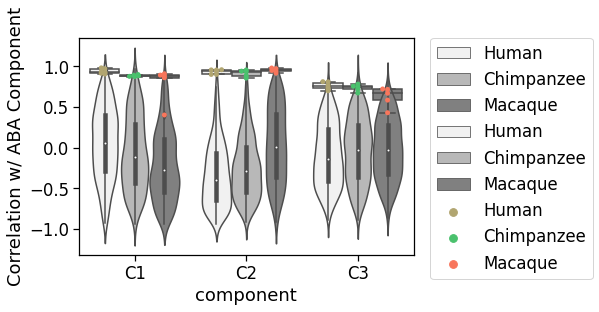

In [39]:
# plot the null distributions as violin plots over the boxplots from 
# earlier. NOTE: this aggregates null distributions across donors
# which doesn't make that much sense, as each donor has different data
# and therefore has their own unique null.
sns.swarmplot(x='component',y='expr',hue='Species',data=tall,dodge=True,palette=pal)
sns.boxplot(x='component',y='expr',hue='Species',data=tall,color='gray')
plt.ylabel('Correlation w/ ABA Component')
g = sns.violinplot(x='component',y='expr',hue='Species2',data=rtall,color='gray')
plt.ylabel('Correlation w/ ABA Component')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(['C1','C2','C3'])
# plt.savefig(os.path.join(figdir,'XSpecies_null_simple.pdf'),
#            bbox_inches='tight')

To overcome the *note* above, I wanted to plot the individual level null distributions against the "true" values. 

In [40]:
tall.loc[:,'ID'] = subsum.ID.tolist() * 3

Text(0, 0.5, 'Regional Correlation to \nABA Expression (r)')

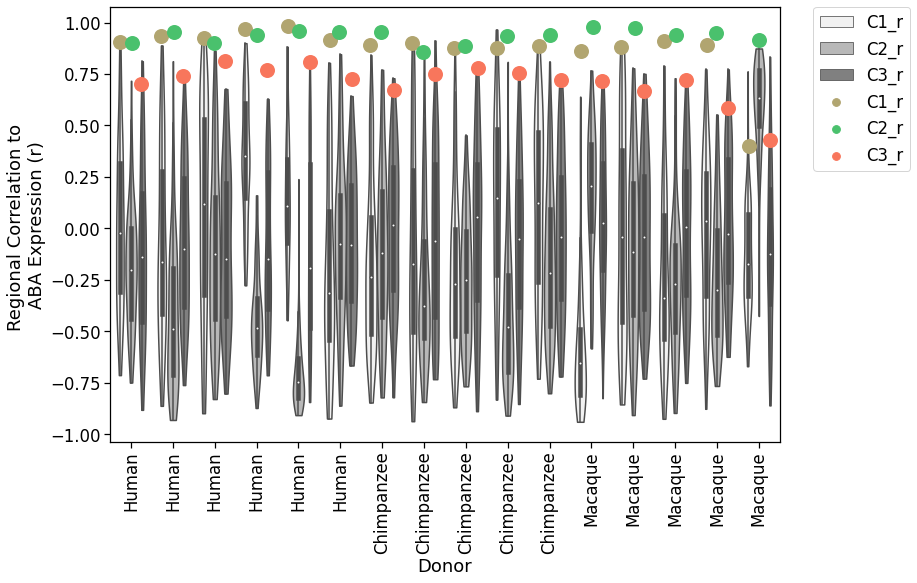

In [41]:
plt.subplots(figsize=(12,8))
sns.stripplot(x='ID',y='expr',hue='component',data=tall,
              palette=pal,dodge=True,s=15)
g = sns.violinplot(x='ID',y='expr',data=rtall,color='gray',cut=0,
                   hue='component')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(subsum.Species.tolist(),rotation=90)
plt.xlabel('Donor')
plt.ylabel('Regional Correlation to \nABA Expression (r)')
# plt.savefig(os.path.join(figdir,'XSpecies_null_indiv.pdf'),
#            bbox_inches='tight')

In [42]:
# generate exact p-values for each subject
for i,row in subsum.iterrows():
    for c in range(1,4):
        null = randos[randos.ID==row['ID']]['C%s_r'%c].sort_values().values
        val = row['C%s_r'%c]
        p = len(null[null>val]) / len(null)
        subsum.loc[i,'C%s_p(r)'%c] = p

In [43]:
subsum.head()

,ID,Species,C1_r,C1_rho,n_valid,C2_r,C2_rho,C3_r,C3_rho,ind,C1_p(r),C2_p(r),C3_p(r)
0,HSB123R,Human,0.904980,0.833333,9.0,0.900514,0.766667,0.699666,0.816667,0,0.0,0.0,0.02
1,HSB126R,Human,0.935237,0.900000,9.0,0.954677,0.900000,0.742410,0.833333,1,0.0,0.0,0.00
2,HSB130L,Human,0.924987,0.983333,9.0,0.900566,0.850000,0.811099,0.816667,2,0.0,0.0,0.00
3,HSB135R,Human,0.970202,0.933333,9.0,0.938157,0.800000,0.769245,0.800000,3,0.0,0.0,0.00
4,HSB136R,Human,0.980903,0.904762,8.0,0.958030,0.690476,0.809696,0.880952,4,0.0,0.0,0.01


# PC comparison

Okay, so these are almost all significant for all components. Not terribly surprising. But, there is maybe another null model necessary. One might just point out that perhaps the overall brain gene expression patterns across species is highly similar, and that any biological signal will be highly reproducible across datasets. So, here we want to set up a distribution of r-values (representing reproducibility) for other biologically meaningful signals, to see how common it is to demonstrate a reproducible regional expression pattern across these datasets.

The easiest way to drum up a bunch of biological signals is probably to use the AHBA prinicipal components. So, we'll create a distribution of r-values across AHBA PCs, and compare our PLS Component r-values to this distribution

In [44]:
pcdiv = pandas.read_csv('./data/Allen_Macrostructure_PCs.csv',index_col = 0)

In [45]:
pcs = pandas.read_csv('./data/Allen_PC_matrix.csv',index_col = 0)

In [306]:
# this is pretty much the same code as above, but adapted to use the
# Allen PCs rather than scrambled data
print('calculating PC expression')
jdf = pandas.DataFrame(columns = pcs.columns)
catch = []
count = 0
for i,ID in enumerate(df.ID.unique()):
    print('working on %s of 16'%(i+1))
    for region in df.ROI.unique():
        jnk = pandas.DataFrame(df[(df.ROI==region) & (df.ID==ID)],copy=True)
        if jnk.shape[0] == 0: continue
        jdf.loc[count,'ID'] = jnk.iloc[0]['ID']
        jdf.loc[count,'ROI'] = jnk.iloc[0]['ROI']
        jdf.loc[count,'Species'] = jnk.iloc[0]['Species']
        jnk.index = jnk.gene_symbol.values
        jnk = jnk.loc[shared]
        jdf.loc[count,pcs.columns] = np.dot(jnk['value'].values,pcs.loc[jnk.index].values)
        count+=1
        #catch.append(jnk)

# calculate similarity
print('calculating similarity')
for name, div in mapper.items():
    jdf.loc[jdf[jdf.ROI.isin(div)].index,'MacroStructure'] = name

# stupid value conversion
jnk = pandas.DataFrame(pandas.to_numeric(jdf[pcs.columns].values.flat,
                                          ).reshape(len(jdf),len(pcs.columns)),
                      index = jdf,columns=pcs.columns)
for col in [x for x in jdf.columns if x not in jnk.columns]:
    jnk.loc[:,col] = jdf[col].values
jdf = jnk

jpdfs = {}
for pc in pcs.columns:
    jpdf = jdf[['ID',pc,'MacroStructure']
                  ].set_index(['ID'],append=True
                             ).pivot_table(index='ID',
                                           columns='MacroStructure',
                                           values=pc)
    #gpdf.drop('GangEm',axis=1,inplace=True)
    for ind,row in jpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        jpdf.loc[ind,'n_valid'] = n_valid
    jpdfs.update({pc: jpdf})

for c in pcs.columns:
    cjdf = jpdfs[c]
    aba = pandas.DataFrame(pcdiv['P%s'%c])
    aba = aba.loc[cjdf.columns[:-1]]
    for i,row in cjdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        if row['n_valid'] > 4:
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['P%s'%c].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['P%s'%c].values,
                              forcorr['gvec'].values)[0]
            cjdf.loc[i,'%s_r'%c] = r
            cjdf.loc[i,'%s_rho'%c] = rho

cols = ['ID', 'Species',]
jsum = pandas.DataFrame(jpdfs[list(jpdfs.keys())[0]].index)
for col in cols:
    jsum.loc[:,col] = jdf.groupby('ID')[col].first().values
for c in pcs.columns:
    jsum.loc[:,'%s_r'%c] = jpdfs[c].loc[:,'%s_r'%c].values
    jsum.loc[:,'%s_rho'%c] = jpdfs[c].loc[:,'%s_rho'%c].values
    jsum.loc[:,'n_valid'] = jpdfs[c].loc[:,'n_valid'].values

calculating PC expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity


In [308]:
subsum.groupby('Species').mean()

,C1_r,C1_rho,n_valid,C2_r,C2_rho,C3_r,C3_rho,ind,C1_p(r),C2_p(r),C3_p(r)
Species,,,,,,,,,,,
Chimpanzee,0.886414,0.890000,8.800000,0.915117,0.807619,0.734975,0.810476,8.0,0.006,0.0,0.010
Human,0.940132,0.900794,8.833333,0.934737,0.792857,0.759394,0.816270,2.5,0.000,0.0,0.005
Macaque,0.787925,0.840952,8.600000,0.951396,0.822857,0.624051,0.682381,13.0,0.006,0.0,0.034


In [346]:
# now let't melt that df
jsum.loc[:,'ind'] = range(len(jsum))
jtall = jsum.melt('ind',[x for x in jsum.columns if '_r' in x and 'ho' not in x],
                  'component','expr')
jtall.loc[:,'Species'] = jsum.Species.tolist() * len(pcs.columns)
jtall.loc[:,'ID'] = jsum.ID.tolist() * len(pcs.columns)

jtall.loc[:,'c'] = [int(x.split('C')[1].split('_')[0]) for x in jtall.component.values]

In [396]:
# generating p-values
comps = pandas.DataFrame(index=jsum.ID.values)
for i,row in jsum.iterrows():
    ID = row['ID']
    dist = row[[x for x in jsum.columns if '_r' in x and 'ho' not in x]].values
    for c in range(1,4):
        val = subsum[subsum.ID==ID]['C%s_r'%c].values[0]
        p = len(dist[dist>val]) / 100
        
        comps.loc[ID,'C%s'%c] = p
    sig = sorted(dist)[95]
    comps.loc[ID,'sig'] = sig

In [397]:
# having a look
comps

,C1,C2,C3,sig
HSB123R,0.03,0.03,0.08,0.875212
HSB126R,0.02,0.02,0.14,0.910868
HSB130L,0.03,0.04,0.07,0.881613
HSB135R,0.00,0.02,0.07,0.836485
HSB136R,0.01,0.02,0.05,0.815354
HSB145R,0.03,0.03,0.13,0.859251
PTB162L,0.03,0.01,0.17,0.851448
PTB164R,0.03,0.03,0.09,0.831503
PTB165R,0.05,0.04,0.10,0.879810
PTB166R,0.06,0.03,0.12,0.930139


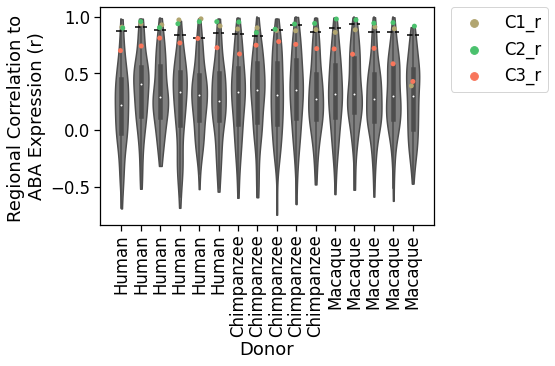

In [402]:
# And now we plot the "null" distribution, along with the "true"
# r-values of the PLS Components
sns.stripplot(x='ID',y='expr',hue='component',data=tall,palette=pal)
g = sns.violinplot(x='ID',y='expr',data=jtall,color='gray',cut=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
count = 0
for i,row in comps.iterrows():
    plt.plot([(count-0.3),(count+0.3)],[row['sig'],row['sig']],ls='--',c='k')
    count+=1
g.set_xticklabels(subsum.Species.tolist(),rotation=90)
plt.xlabel('Donor')
plt.ylabel('Regional Correlation to \nABA Expression (r)')
# plt.savefig(os.path.join(figdir,'XSpecies_signull_indiv.pdf'),
#            bbox_inches='tight')